# Barren plateaus and ansatz entanglement structures in Quantum Machine Learning

Barren plateaus are a phenomenon in the gradient-based training of quantum variational circuits whereby the training landscape for the parameters of the circuit is flat, and this can be observed as an exponential decrease in the variance of the gradients as a function of the number of qubits in the circuit.

In this notebook, different Variational Quantum Classifiers using the four different entanglement schemes (linear, full, circular, shifted-circular-alternating) in the qiskit module are trained on generated datasets from sklearn. The concentration of cost about the mean is calculated during the training of these classifiers and are compared for the different entanglement schemes. Additionally, the von Neumann entropy of entanglement for each circuit is tracked over the training of the models.

### Note: 
Certain parts of this notebook, such as the training of the classifiers and the calculation of von Neumann entanglement entropy, take multiple hours to run. To enable the user to run the entire notebook with no issues, these calls have been commented out. The precomputed results from these calls have been saved to files, which are read when the results are plotted, so the plotted results will still work. If you wish to run the entire experiment, simply uncomment these function calls.

In [1]:
import qiskit
from qiskit import Aer, execute
from qiskit.quantum_info import entropy, Statevector, DensityMatrix
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit.visualization import circuit_drawer

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from qutip import Qobj

import numpy as np
import pandas as pd
import itertools
import joblib
import timeit

## Create the datasets to be used by the VQCs.

Define the settings for the number of qubits and number of reps. Each of the circuits that are created will use some combination of these values for the corresponding settings.

In [2]:
num_qubits = [3,4,5,6,7]
num_reps = [1,5,10,15]

Create and process the various datasets.

In [3]:
datasets = {}

for n in num_qubits:
    # create the dataset
    X, y = make_blobs(n_features=n,centers=2)
    # standardize the data
    X_s = StandardScaler().fit_transform(X)
    
    # change the labels from {0, 1} to {-1, 1}
    y = 2 * y - 1
    
    datasets[n] = [X_s, y]

Save the datasets so that they may be reused.

In [4]:
#joblib.dump(datasets, './Datasets/datasets.txt')

If the datasets have already been created, then read them from their file.

In [5]:
datasets = joblib.load('./Datasets/datasets.txt')

## Create the configurations from which the various Parameterized Quantum Circuits will be generated.

The configurations contain settings for the number of qubits, the entanglement scheme used in the ansatz, the number of reps of the ansatz, and the dataset whose dimensionality matches the input dimension of the circuit.

In [6]:
entanglement_modes = ['linear','full','circular','sca']

list_of_config_tuples = list(itertools.product(entanglement_modes, num_qubits, num_reps))

# assign each config its matching dataset
configs = []
for c in list_of_config_tuples:
    config = list(c)
    config.append(datasets[c[1]])
    configs.append(config)

print('Config 1:\nEntanglement Mode: ',configs[0][0],' | Num qubits: ',configs[0][1],' | Num reps: ',configs[0][2])

Config 1:
Entanglement Mode:  linear  | Num qubits:  3  | Num reps:  1


## The different entanglement schemes which will be compared

Below are examples of variational forms which demonstrate the architecture for each of the entanglement schemes, using 3 qubits and one repetition. For the variational form using SCA entanglement, we use 2 repetitions so that the differences between this scheme and the circular entanglement scheme are visible. 

Ansatz using the  Linear  entanglement scheme, with 3 qubits and 1 repetition:


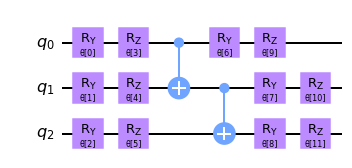

In [7]:
ansatz_example_1 = EfficientSU2(num_qubits=configs[0][1],entanglement=configs[0][0],reps=configs[0][2]).decompose()
print('Ansatz using the ',configs[0][0].capitalize(),' entanglement scheme, with 3 qubits and 1 repetition:')
circuit_drawer(ansatz_example_1, output='mpl')

Ansatz using the  Full  entanglement scheme, with 3 qubits and 1 repetition:


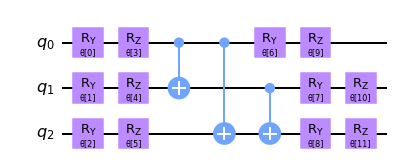

In [8]:
ansatz_example_2 = EfficientSU2(num_qubits=configs[20][1],entanglement=configs[20][0],reps=configs[20][2]).decompose()
print('Ansatz using the ',configs[20][0].capitalize(),' entanglement scheme, with 3 qubits and 1 repetition:')
circuit_drawer(ansatz_example_2, output='mpl')

Ansatz using the  Circular  entanglement scheme, with 3 qubits and 1 repetition:


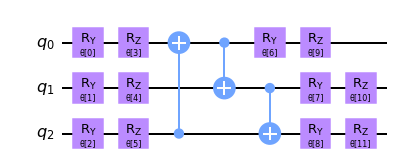

In [9]:
ansatz_example_3 = EfficientSU2(num_qubits=configs[40][1],entanglement=configs[40][0],reps=configs[40][2]).decompose()
print('Ansatz using the ',configs[40][0].capitalize(),' entanglement scheme, with 3 qubits and 1 repetition:')
circuit_drawer(ansatz_example_3, output='mpl')

Ansatz using the  Sca  entanglement scheme, with 3 qubits and 2 repetitions:


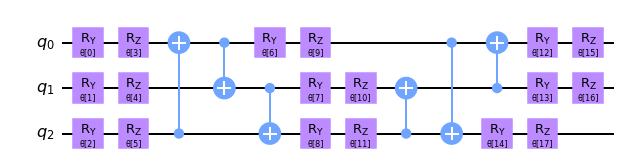

In [10]:
ansatz_example_4 = EfficientSU2(num_qubits=3,entanglement='sca',reps=2).decompose()
print('Ansatz using the ',configs[60][0].capitalize(),' entanglement scheme, with 3 qubits and 2 repetitions:')
circuit_drawer(ansatz_example_4, output='mpl')

## Create and train the Neural Network classifier using the configurations generated

Using the configurations, create the Variational circuits, the Quantum Neural Networks, and the Neural Network Classifiers to be trained using the generated datasets.

An example of the feature map and ansatz, as well as the circuit built with them:

Feature map for Config 1:


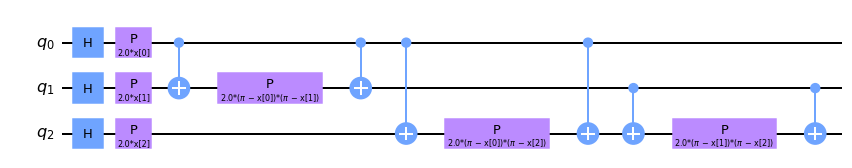

In [11]:
feature_map_example = ZZFeatureMap(configs[0][1],reps=1).decompose()
print('Feature map for Config 1:')
circuit_drawer(feature_map_example, output='latex_source',filename='ZZFeatureMap3qubits1rep.tex')
circuit_drawer(feature_map_example, output='mpl')

Now using the feature map and the ansatz with the linear entanglement scheme, we can obtain the complete circuit.

Thus, the variational circuit for Config 1:


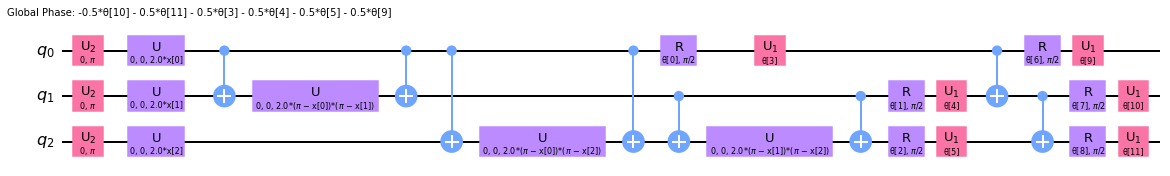

In [12]:
circuit_example = feature_map_example.compose(ansatz_example_1).decompose()
print('Thus, the variational circuit for Config 1:')
circuit_drawer(circuit_example,output='mpl')

The AlteredSPSA class contains a version of the gradient-free SPSA optimizer which has been altered so that it writes the parameters at each training iteration to a csv file called 'spsa_params.csv'. It also contains the TrackingResult class, which provides a convenient container for all of the information of interest in the use_config call.

In [13]:
from AlteredSPSA import *

qiskit.utils.algorithm_globals.random_seed = 14     # set the random seed so that the behaviour of the optimizer is reproducible

In order to identify a barren plateau in the cost landscape without using gradients, it is necessary to measure the concentration of the cost values about the mean. The function below calculates the cost differences for each epoch of the optimization process, and takes the list of costs calculated during the optimization process as an argument.

In [14]:
def cost_differences(costs):
    
    mean_cost = np.average(costs)
    differences = []
    for i in costs:
        diff = mean_cost - i
        differences.append(diff)
        
    return differences

The method below creates the variational circuit, uses this to generate the quantum neural network, and then creates the Neural Network Classifier, which it trains using the configuration's dataset.

In [15]:
from qiskit.opflow import Gradient, StateFn, PauliExpectation, Z, I

from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

def use_config(config, q_instance):
    # this directory is given to the optimizer to store the parameters at each iteration
    params_csv = './Parameters/'+config[0]+'/'+str(config[1])+' qubits/'+str(config[2])+' reps'
    
    # create the feature map
    feature_map = ZZFeatureMap(config[1],reps=1)
    # create the ansatz
    ansatz = EfficientSU2(num_qubits=config[1],entanglement=config[0],reps=config[2])
    # create the variational circuit
    circuit = feature_map.compose(ansatz)
    
    # define the local operator for the expectation values
    hamiltonian = Z ^ Z ^(I ^ (config[1]-2))
    
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    
    # create the quantum neural network
    qnn = OpflowQNN(expectation,
                    input_params=list(feature_map.parameters),
                    weight_params=list(ansatz.parameters),
                    exp_val=PauliExpectation(),
                    gradient=Gradient(),
                    quantum_instance=q_instance)
    
    # define an inline callback function for the loss values
    spsa_loss = []
    def spsa_callback(nfev, x, fx, stepsize, accepted):
        spsa_loss.append(fx)
    
    # the classical optimizer which will update the parameters of the circuit in the training process
    optimizer = AlteredSPSA(maxiter=200, learning_rate=0.01, perturbation=0.01, callback=spsa_callback, snapshot_dir=params_csv)
    
    # create the neural network classifier using the qnn
    classifier = NeuralNetworkClassifier(qnn,optimizer=optimizer)
    
    # time the training of the classifier
    start = timeit.default_timer()
    
    # train the optimizer on the training data
    classifier.fit(config[3][0],config[3][1])
    
    elapsed = timeit.default_timer() - start
    
    # create the tracking object for this classifier
    tracking_object = TrackingResult(config[1],                         # the number of qubits
                                     config[2],                         # the number of reps
                                     config[0],                         # the entanglement mode
                                     spsa_loss,                         # the loss at each iteration of optimization
                                     cost_differences(spsa_loss),       # the differences between mean cost and calculated cost
                                     params_csv)                        # the parameter file path
    
    # save the tracking object
    file = './Results/Without Entropy/'+config[0]+'/'+str(config[1])+' qubits and '+str(config[2])+' reps.txt'
    joblib.dump(tracking_object,file)
    
    return_string = '\nDone with config: '+config[0]+' with '+str(config[1])+' qubits and '+str(config[2])+' reps\nTime taken: '+str(elapsed)+' seconds'
    return return_string

## Create and train the classifiers for each configuration

Here, the Quantum Neural Network classifiers using the PQC's are trained with the generated data sets; this is done in parallel.

Note: This code may take a few hours to run, so the function call to train the classifiers is commented out.

In [16]:
# create the backend and quantum instance on which the circuits will run
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend, shots=1)

# this will run using 28 threads. Adjust this number accordingly to suit your CPU
parallel_pool = joblib.Parallel(n_jobs=28)      

# use the configs in parallel
#return_values = parallel_pool(joblib.delayed(use_config)(c, q_instance) for c in configs)

#for i in return_values:
    #print(i)

## Calculate the von Neumann Entropy of Entanglement at each training epoch for the Classifiers.


In [17]:
# this method processes the parameters so that they may easily be assigned to the circuits
def get_data_dict(params, x, ansatz, feature_map):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [18]:
# this method returns the correct dims for the Qobj object, which is important for the partial trace
def dims(num_qubits):
    rows=[]
    cols=[]
    for i in range(num_qubits):
        rows.append(2)
        cols.append(1)
    return [rows, cols]

The method below calculates the entropy at each epoch for a given configuration. This method uses the parameters stored in the spsa_params.csv files, and so this method must only be called after the classifiers have been trained.

The initial state of the system is $$ |0\rangle^{\otimes n} $$ where n is the number of qubits in the circuit. The parameters are assigned to the circuit, and then the variational circuit is run using the initial state, thereby obtaining statevector representing the final state of the quantum system.

The partial density matrix is then obtained by using a partial trace to trace out a bi-partition of qubits from the system, and the entropy is calculated using this partial density matrix. This is done for all possible bi-partitions, and the average entropy of entanglement is returned. 

In [19]:
backend = Aer.get_backend('statevector_simulator')

def calculate_entropy(config):

    entanglement_mode = config[0]
    num_qubits = config[1]
    num_reps = config[2]
    dataset = config[3]
    training_data = dataset[0]
    
    # load the tracking result object for the config from its file
    result_path = './Results/Without Entropy/' + entanglement_mode + "/" + str(num_qubits) + " qubits and " + str(num_reps) + " reps.txt"
    tracking_object = joblib.load(result_path)
    
    # load the data from the parameters file
    parameter_csv = tracking_object.params_file + '/spsa_params.csv'
    df = pd.read_csv(parameter_csv) #, usecols=['m'])
    
    # process the file and obtain a list of parameter sets
    arr = df.to_numpy()
    param_array = []
    for i in arr:
        a_list = i[1].rstrip(']').lstrip('[').split()
        map_object = map(float, a_list)
        list_of_integers = list(map_object)
        param_array.append(list_of_integers)

    # recreate circuit used in the classifier
    feature_map = ZZFeatureMap(num_qubits, reps=1)
    ansatz = EfficientSU2(num_qubits=num_qubits, entanglement=entanglement_mode,
                          reps=num_reps)
    circuit = feature_map.compose(ansatz)

    # obtain the partitions that will be traced out of the density matrix
    qubits = [x for x in range(num_qubits)]
    combinations = itertools.combinations(qubits, 2)
    partitions = []

    for c in combinations:
        partitions.append(c)

    # calculate the entropy for each training epoch using the stored parameters
    vn_entropy = []
    for p in param_array:

        vN = 0
        
        # the initial state of the system
        state_vector = Statevector.from_label('0' * num_qubits)
            
        circ_ = circuit.assign_parameters(get_data_dict(p, training_data[0], ansatz, feature_map))

        # evolve the initial statevector by the circuit
        qc = state_vector.evolve(circ_)

        # execute the circuit 50 times and obtain the final statevector
        ckt_state = execute(circ_, backend, shots=50).result().get_statevector()

        for part in partitions:

            # create a Quantum Object from the statevector
            stateV = Qobj(ckt_state, dims=dims(num_qubits))
            partialDensityMatrix = stateV.ptrace([x for x in qubits if x not in part])
            dM = DensityMatrix(partialDensityMatrix.full())
            vN += entropy(dM) / len(partitions)

        vn_entropy.append(vN)
    
    # store the list of entropies in the tracking result objects respective attribute
    tracking_object.entropies = vn_entropy

    # save the now complete tracking result object
    final_path = './Results/With Entropy/' + entanglement_mode + "/" + str(num_qubits) + " qubits and " + str(num_reps) + " reps.txt"
    joblib.dump(tracking_object, final_path)

Calculate the entropy of entanglement of each training epoch for each configuration.

Note: Once again, this code may take a while to run, so it is commented out.

In [20]:
#parallel_pool(joblib.delayed(calculate_entropy)(c) for c in configs)

# Loss of the Classifiers over the training process

It is useful to plot the classifiers loss at each training epoch to visualize the change in performance in the model during the training process.

In [21]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_loss(results):
    epochs = [x for x in range(1+len(results[0].entropies))]
    plt.figure(figsize=(12,6))
    
    for r in results:
        
        entanglement = r.entanglement.capitalize()

        label_string = str(r.num_qubits) + ' qubits, ' + str(r.num_reps) + ' layers'
        plt.plot(epochs, r.loss, label=label_string)
        plt.legend(loc='best', fontsize='x-small')

        plt.title(entanglement.capitalize() + " Entanglement")
        plt.xlabel('Training Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best', fontsize='x-small')

    plt.show() 

In [22]:
modes = ['linear','full','circular','sca']
num_qubits = [3,4,5,6,7]
num_reps = [1,5,10,15]

results = {}

for m in modes:
    
    same_qubit_circuits = {3:[], 4:[], 5:[], 6:[], 7:[]}
    
    for r in num_reps:
        for n in num_qubits:
            
            file = './Results/With Entropy/' + m + '/' + str(n) + ' qubits and ' + str(r) + ' reps.txt'

            tracking_object = joblib.load(file)
            same_qubit_circuits[tracking_object.num_qubits].append(tracking_object)
    
    results[m] = same_qubit_circuits

## Loss for circuits using 3 qubits.

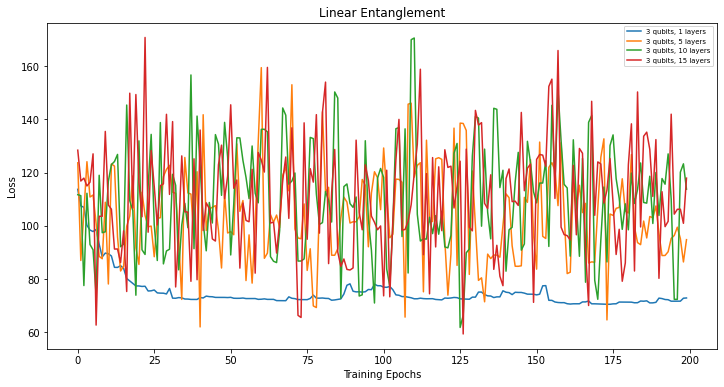

In [23]:
# plot the loss for the Linear Entanglement with 3 qubits
plot_loss(results['linear'][3])

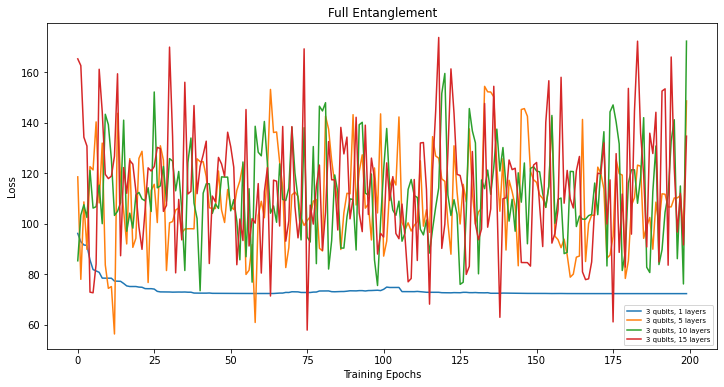

In [24]:
# plot the loss for the Full Entanglement with 3 qubits
plot_loss(results['full'][3])

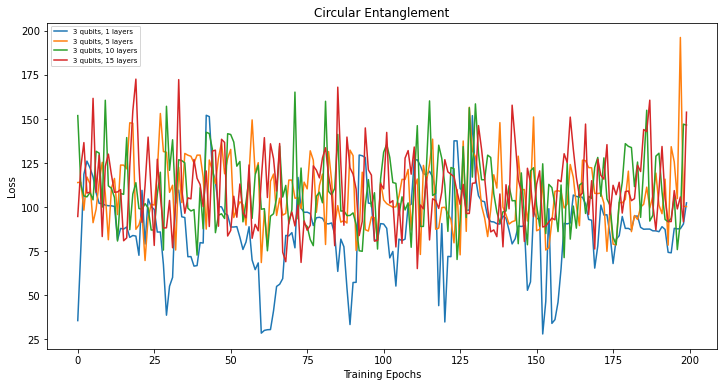

In [25]:
# plot the loss for the Circular Entanglement with 3 qubits
plot_loss(results['circular'][3])

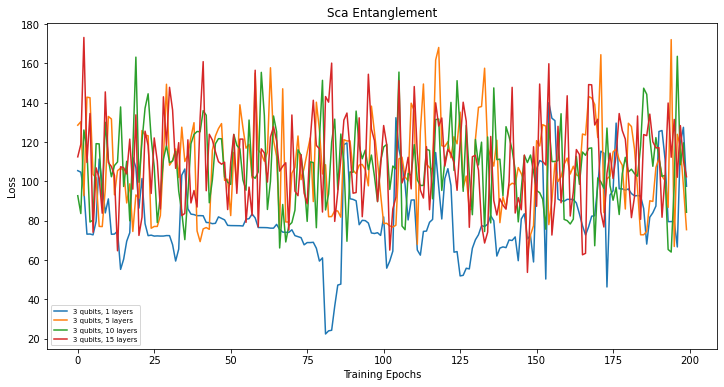

In [26]:
# plot the loss for the SCA Entanglement with 3 qubits
plot_loss(results['sca'][3])

## Loss for circuits using 4 qubits.

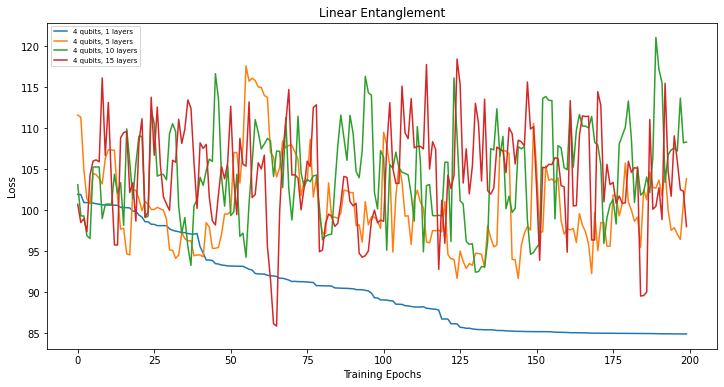

In [27]:
# plot the loss for the Linear Entanglement with 4 qubits
plot_loss(results['linear'][4])

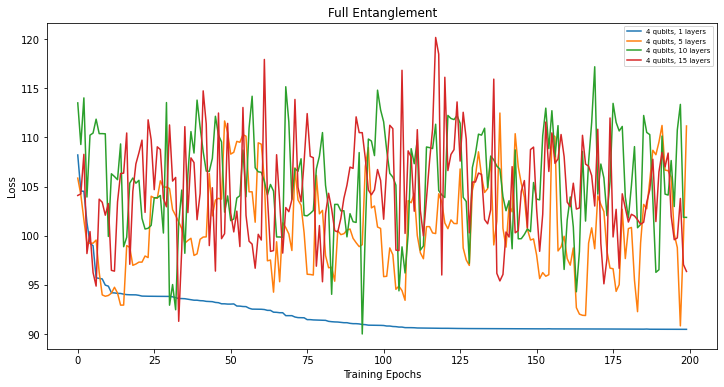

In [28]:
# plot the loss for the Full Entanglement with 4 qubits
plot_loss(results['full'][4])

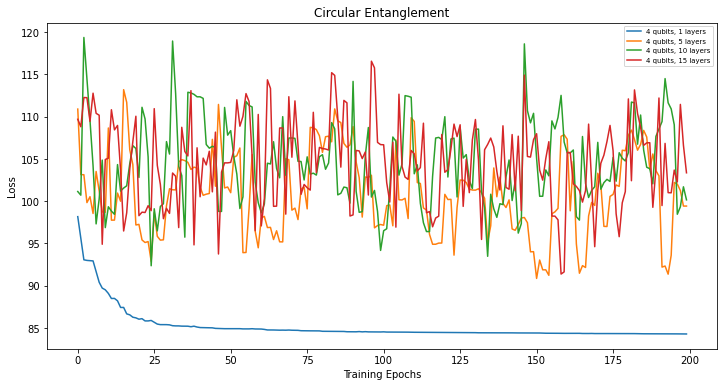

In [29]:
# plot the loss for the Circular Entanglement with 4 qubits
plot_loss(results['circular'][4])

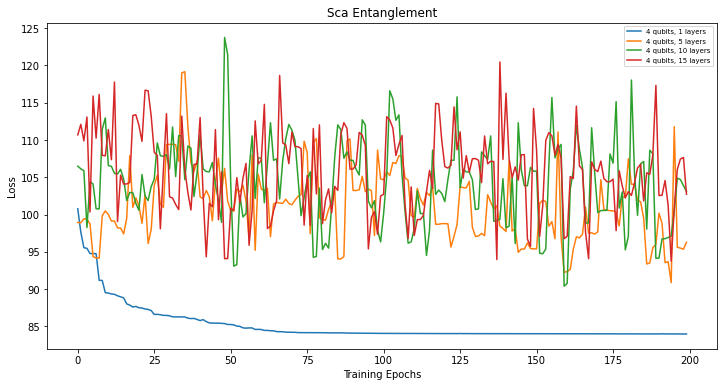

In [30]:
# plot the loss for the SCA Entanglement with 4 qubits
plot_loss(results['sca'][4])

## Loss for circuits using 5 qubits.

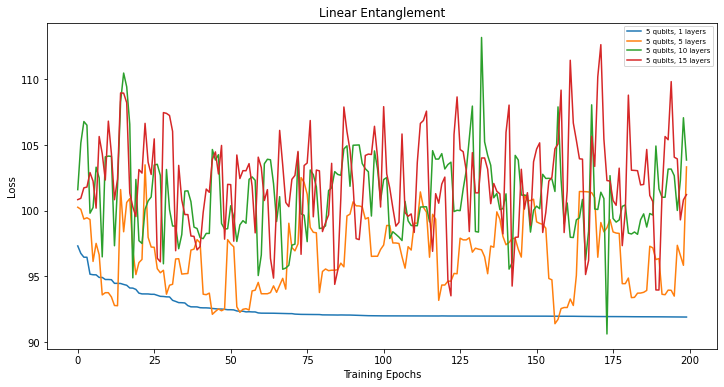

In [31]:
# plot the loss for the Linear Entanglement with 5 qubits
plot_loss(results['linear'][5])

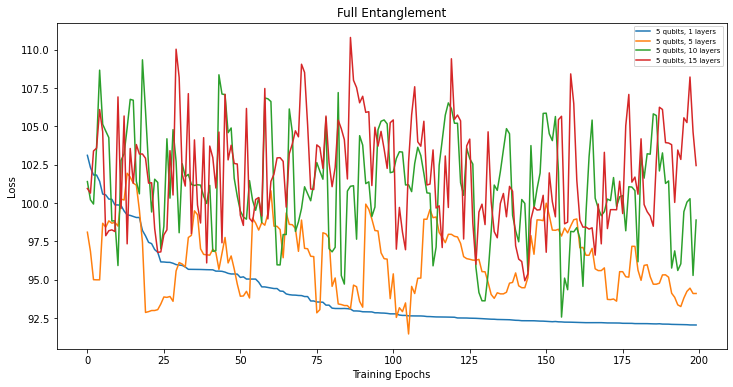

In [32]:
# plot the loss for the Full Entanglement with 5 qubits
plot_loss(results['full'][5])

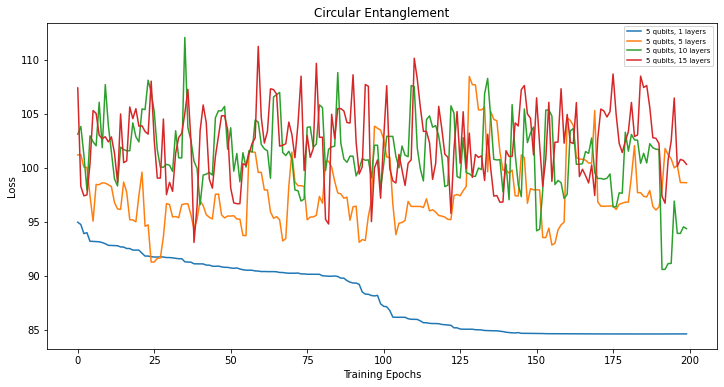

In [33]:
# plot the loss for the Circular Entanglement with 5 qubits
plot_loss(results['circular'][5])

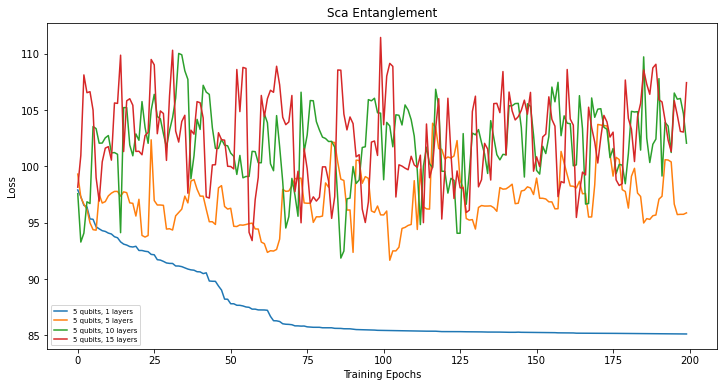

In [34]:
# plot the loss for the SCA Entanglement with 5 qubits
plot_loss(results['sca'][5])

## Loss for circuits using 6 qubits.

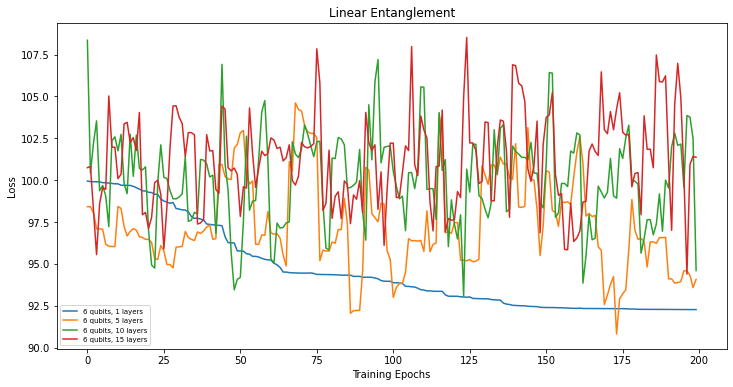

In [35]:
# plot the loss for the Linear Entanglement with 6 qubits
plot_loss(results['linear'][6])

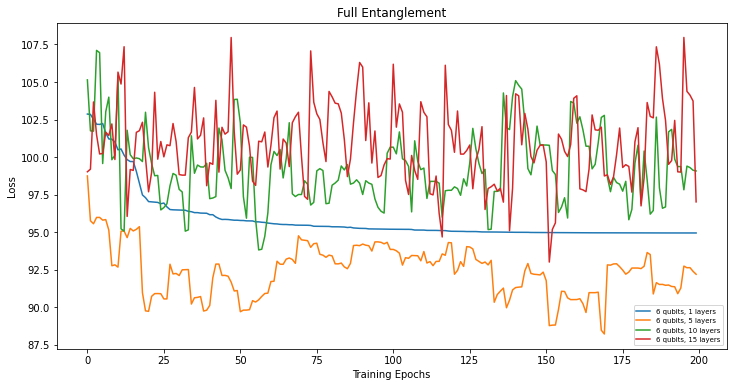

In [36]:
# plot the loss for the Full Entanglement with 6 qubits
plot_loss(results['full'][6])

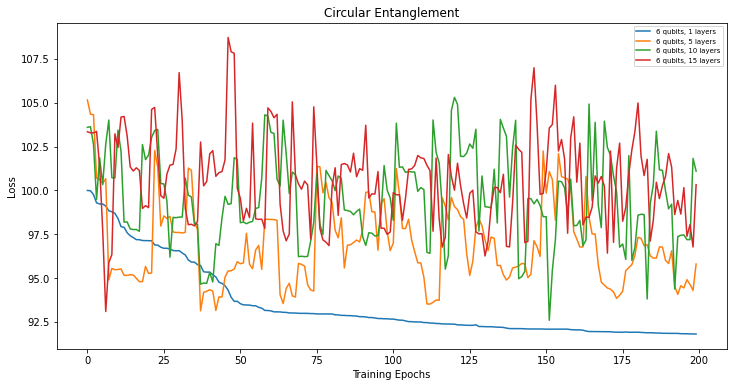

In [37]:
# plot the loss for the Circular Entanglement with 6 qubits
plot_loss(results['circular'][6])

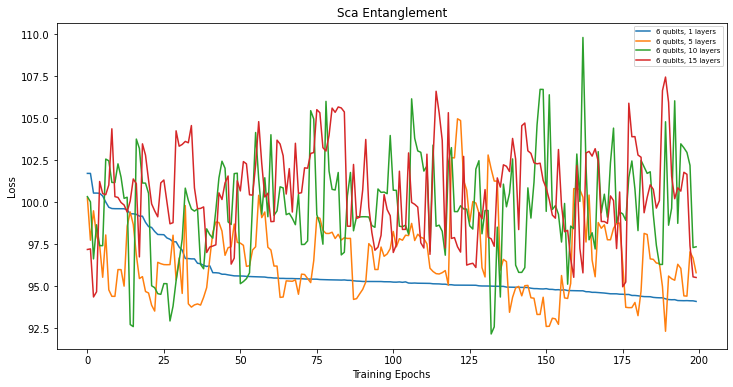

In [38]:
# plot the loss for the SCA Entanglement with 6 qubits
plot_loss(results['sca'][6])

## Loss for circuits using 7 qubits.

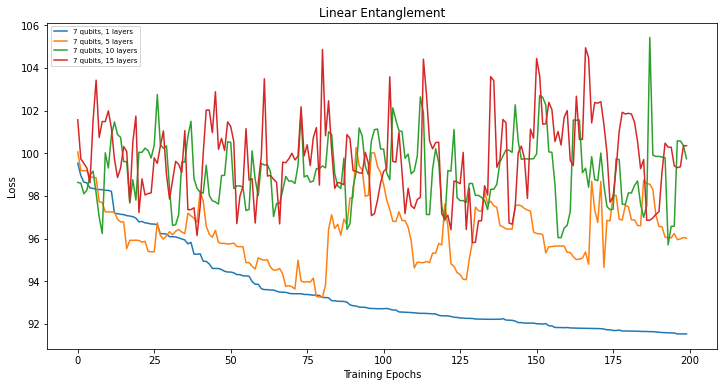

In [39]:
# plot the loss for the Linear Entanglement with 7 qubits
plot_loss(results['linear'][7])

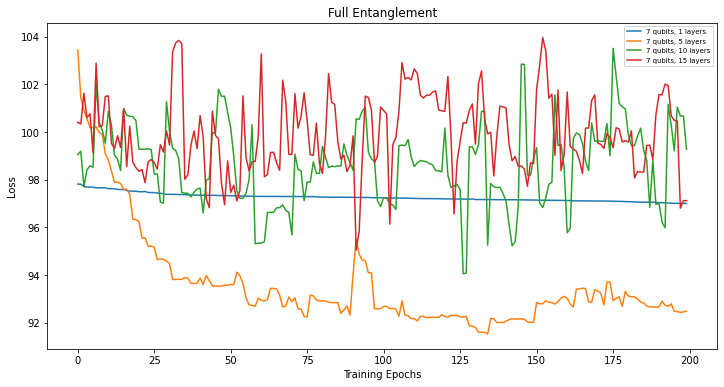

In [40]:
# plot the loss for the Full Entanglement with 7 qubits
plot_loss(results['full'][7])

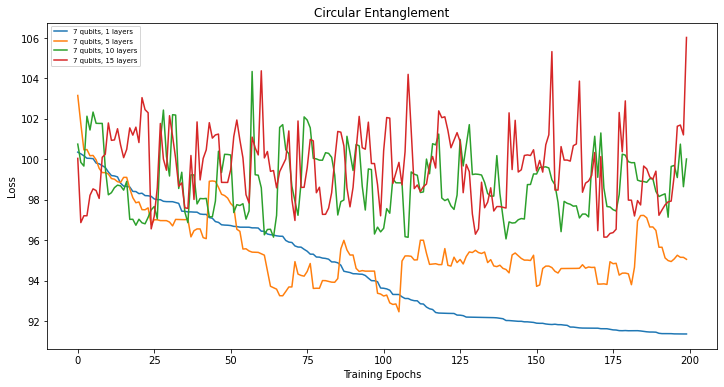

In [41]:
# plot the loss for the Circular Entanglement with 7 qubits
plot_loss(results['circular'][7])

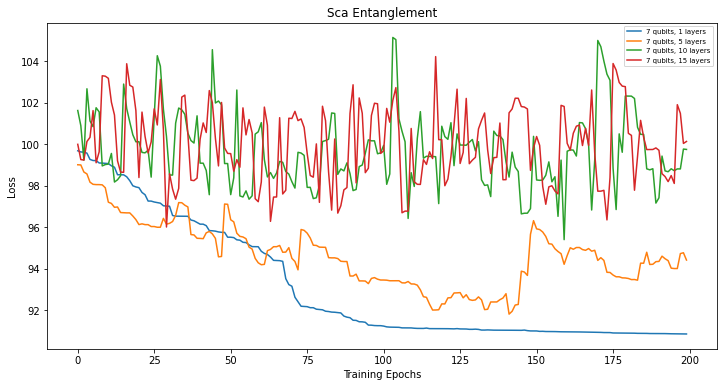

In [42]:
# plot the loss for the SCA Entanglement with 7 qubits
plot_loss(results['sca'][7])

# Variance of cost function differences as a function of the number of qubits

Now that the Neural Network classifiers for each configuration have been trained, the training cost function differences have been stored, and the von Neumann entropy of entanglement at each training epoch has been calculated, we can plot the results.

In [43]:
def plot_concentration(results, num_qubits, num_reps, entanglement):
    
    plt.figure(figsize=(12,6))
    fitted_lines = []
    
    for r in range(len(results)):
        
        if r == 0:
            reps = 1
        else:
            reps = r*5
        
        label_string = str(reps)+' layers'
        plt.semilogy(num_qubits, np.var(results[r], axis=1), 'o-', label=label_string)
        plt.legend(loc='best', fontsize='large')

        fit = np.polyfit(num_qubits, np.log(np.var(results[r], axis=1)), deg=1)
        x = np.linspace(num_qubits[0], num_qubits[-1], 200)

        fitted_lines.append([fit, x])

        plt.title(entanglement + " Entanglement",fontsize='xx-large')
        plt.xlabel('Number of qubits',fontsize='xx-large')
        plt.ylabel(r'$\mathrm{Var}_{\theta_{A}}[E[C(\theta)] - C(\theta_{A}) ]$',fontsize='xx-large')
        plt.xticks(fontsize='x-large')
        plt.yticks(fontsize='x-large')
        plt.legend(loc='best', fontsize='large')
    
    # fit lines to the 1 layer circuit and the 15 layer circuit
    indices_of_interest = [0,len(fitted_lines)-1]
    
    for i in indices_of_interest:
        if i == 0:
            # plot the fitted line
            plt.semilogy(x, np.exp(fitted_lines[i][0][0] * x + fitted_lines[i][0][1]), 'b--', label=f'exponential fit w/ {fitted_lines[i][0][0]:.2f}')
        else:
            # plot the fitted line
            plt.semilogy(x, np.exp(fitted_lines[i][0][0] * x + fitted_lines[i][0][1]), 'r--', label=f'exponential fit w/ {fitted_lines[i][0][0]:.2f}')
   
    plt.legend(loc='best', fontsize='large')
    plt.show()

Now read the tracking result objects from their files and process them for plotting.

In [44]:
results = {}
for m in entanglement_modes:
    
    mode_results = []
    for r in num_reps:
        
        set_depth = []
        for n in num_qubits:
            # read the objects from their files
            file = './Results/With Entropy/' + m + '/' + str(n) + ' qubits and ' + str(r) + ' reps.txt'
            tracking_object = joblib.load(file)
            set_depth.append(tracking_object.loss_differences)

        mode_results.append(set_depth)

    results[m] = mode_results

## Using the Linear Entanglement scheme for the ansatz.

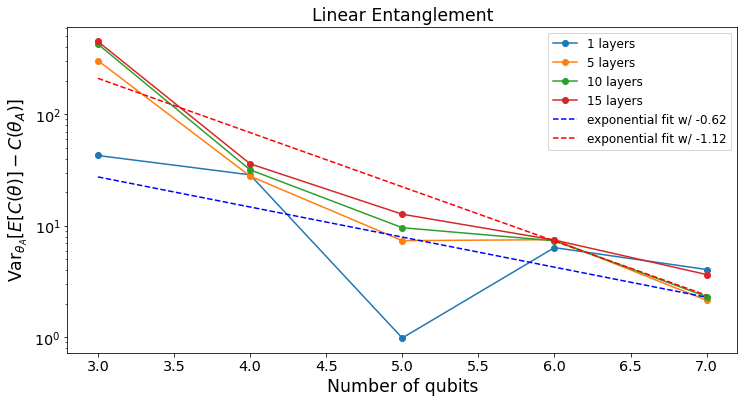

In [45]:
# plot the Linear Entanglement cost concentration results
plot_concentration(results['linear'],num_qubits,num_reps,'Linear')

## Using the Full Entanglement scheme for the ansatz.

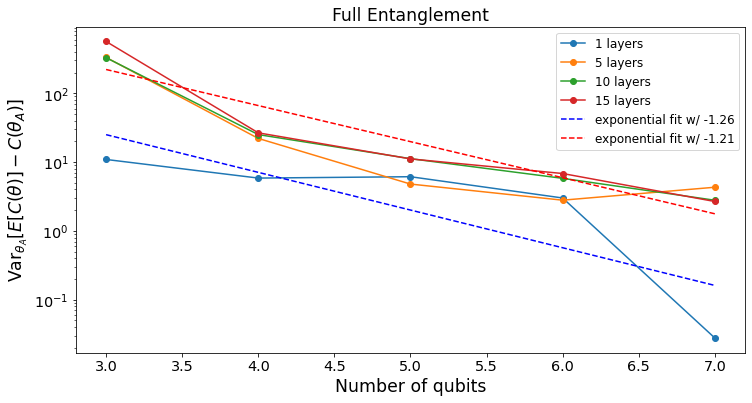

In [46]:
# plot the Full Entanglement cost concentration results
plot_concentration(results['full'],num_qubits,num_reps,'Full')

## Using the Circular Entanglement scheme for the ansatz.

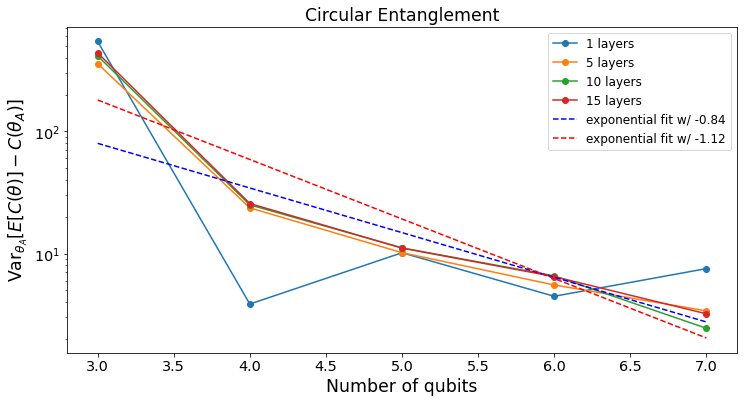

In [47]:
# plot the Circular Entanglement cost concentration results
plot_concentration(results['circular'],num_qubits,num_reps,'Circular')

## Using the SCA Entanglement scheme for the ansatz.

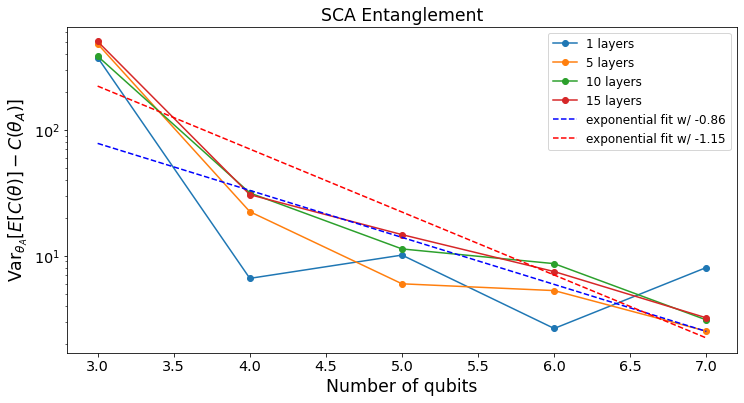

In [48]:
# plot the SCA Entanglement cost concentration results
plot_concentration(results['sca'],num_qubits,num_reps,'SCA')

# The von Neumann Entropy of Entanglement for each training epoch

Next we can plot the entropies of entanglement.

In [49]:
def plot_entropies(results):

    epochs = [x for x in range(len(results[0].entropies))]
    plt.figure(figsize=(12,6))
    
    for r in results:
        
        num_qubits = r.num_qubits
            
        entanglement = r.entanglement.capitalize()

        label_string = str(r.num_qubits) + ' qubits, ' + str(r.num_reps) + ' layers'
        plt.plot(epochs, r.entropies, label=label_string)
        plt.legend(loc='best', fontsize='x-small')

        plt.title(entanglement.capitalize() + " Entanglement",fontsize='x-large')
        plt.xlabel('Training Epochs',fontsize='x-large')
        plt.ylabel('von Neumann Entropy of Entanglement',fontsize='x-large')
        plt.xticks(fontsize='x-large')
        plt.yticks(fontsize='x-large')
        plt.legend(loc='best', fontsize='medium')
    plt.show()

In [50]:
results = {}

for m in modes:
    
    same_qubit_circuits = {3:[], 4:[], 5:[], 6:[], 7:[]}
    
    for r in num_reps:
        for n in num_qubits:
            
            file = './Results/With Entropy/' + m + '/' + str(n) + ' qubits and ' + str(r) + ' reps.txt'

            tracking_object = joblib.load(file)
            same_qubit_circuits[tracking_object.num_qubits].append(tracking_object)
    
    results[m] = same_qubit_circuits

## Entropy measures for the circuits using 3 qubits.

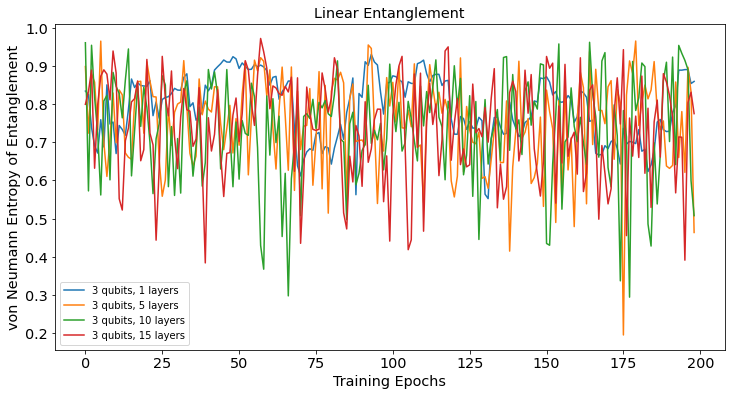

In [51]:
# plot the vN entropies for the Linear Entanglement with 3 qubits
plot_entropies(results['linear'][3])

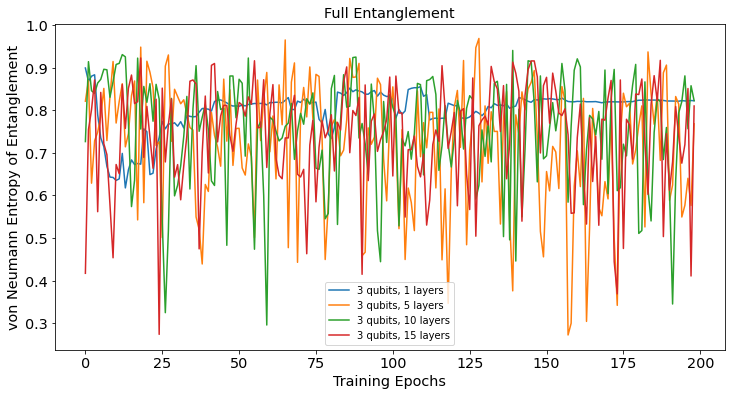

In [52]:
# plot the vN entropies for the Full Entanglement with 3 qubits
plot_entropies(results['full'][3])

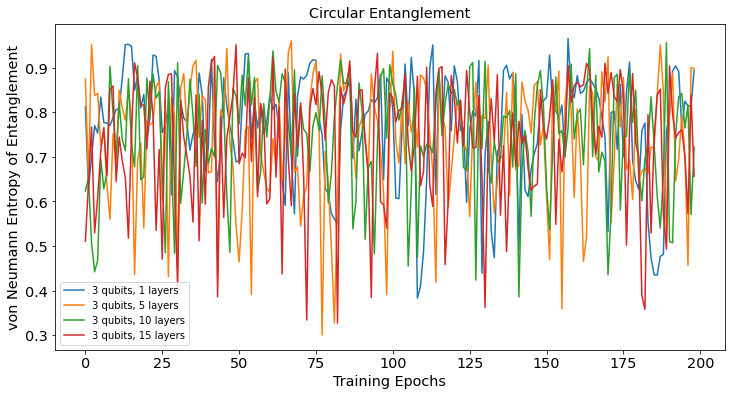

In [53]:
# plot the vN entropies for the Circular Entanglement with 3 qubits
plot_entropies(results['circular'][3])

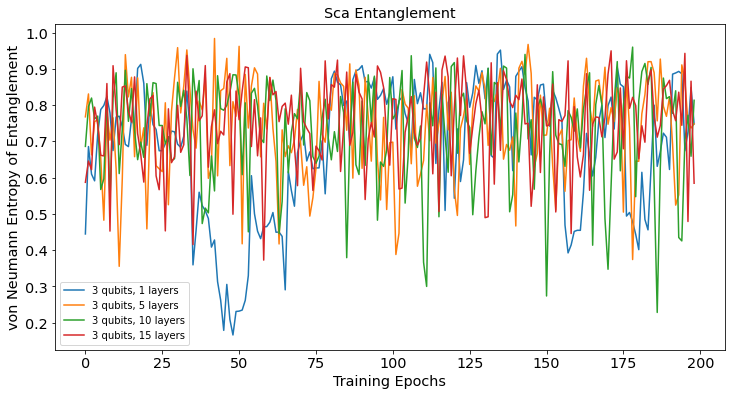

In [54]:
# plot the vN entropies for the SCA Entanglement with 3 qubits
plot_entropies(results['sca'][3])

## Entropy measures for the circuits using 4 qubits.

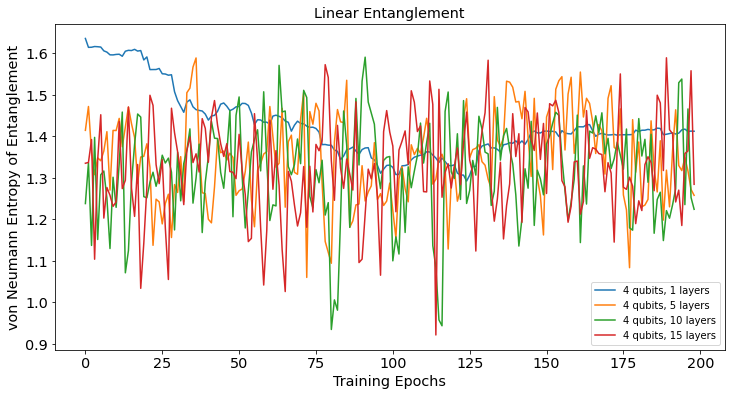

In [55]:
# plot the vN entropies for the Linear Entanglement with 4 qubits
plot_entropies(results['linear'][4])

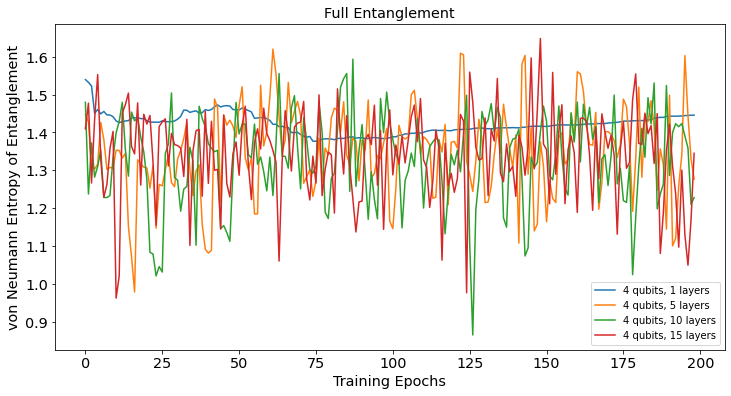

In [56]:
# plot the vN entropies for the Full Entanglement with 4 qubits
plot_entropies(results['full'][4])

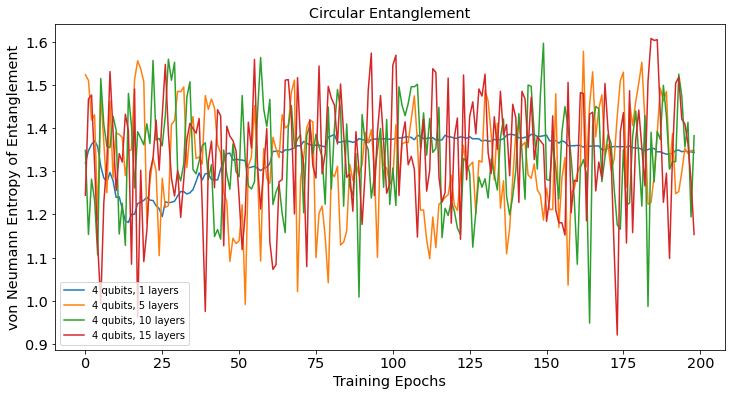

In [57]:
# plot the vN entropies for the Circular Entanglement with 4 qubits
plot_entropies(results['circular'][4])

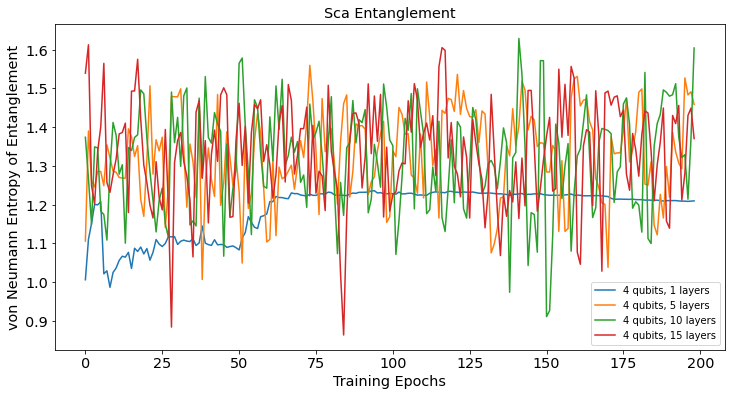

In [58]:
# plot the vN entropies for the SCA Entanglement with 4 qubits
plot_entropies(results['sca'][4])

## Entropy measures for the circuits using 5 qubits.

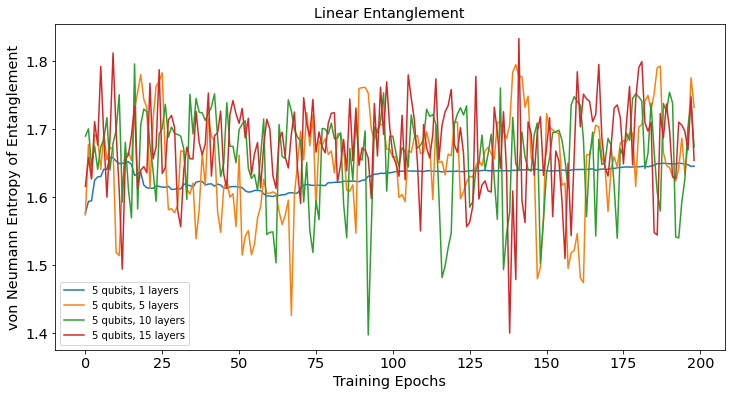

In [59]:
# plot the vN entropies for the Linear Entanglement with 5 qubits
plot_entropies(results['linear'][5])

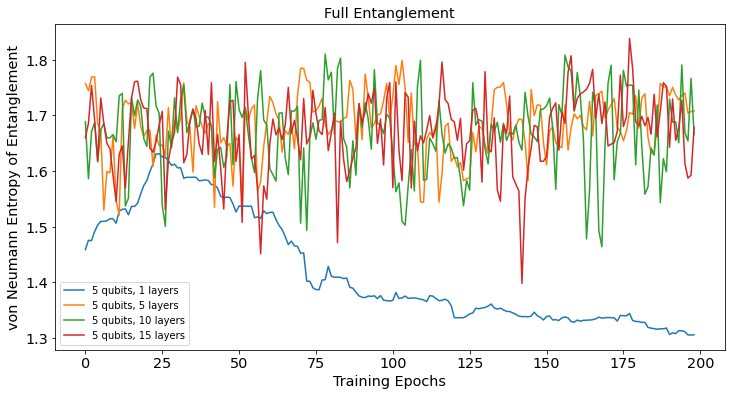

In [60]:
# plot the vN entropies for the Full Entanglement with 5 qubits
plot_entropies(results['full'][5])

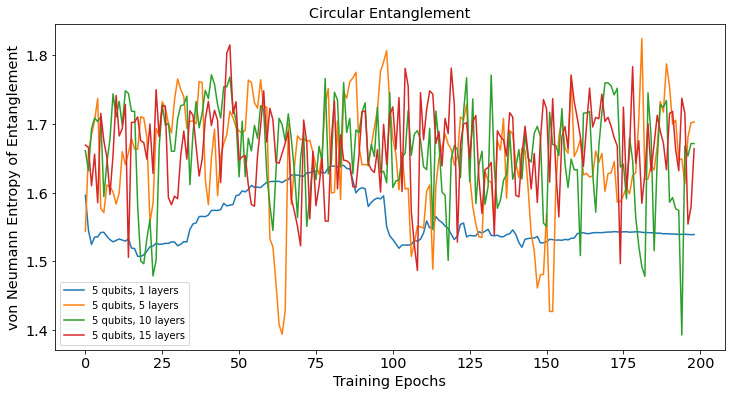

In [61]:
# plot the vN entropies for the Circular Entanglement with 5 qubits
plot_entropies(results['circular'][5])

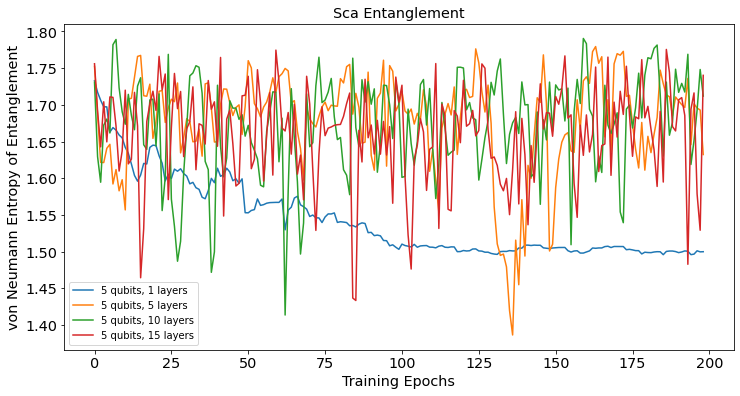

In [62]:
# plot the vN entropies for the SCA Entanglement with 5 qubits
plot_entropies(results['sca'][5])

## Entropy measures for the circuits using 6 qubits.

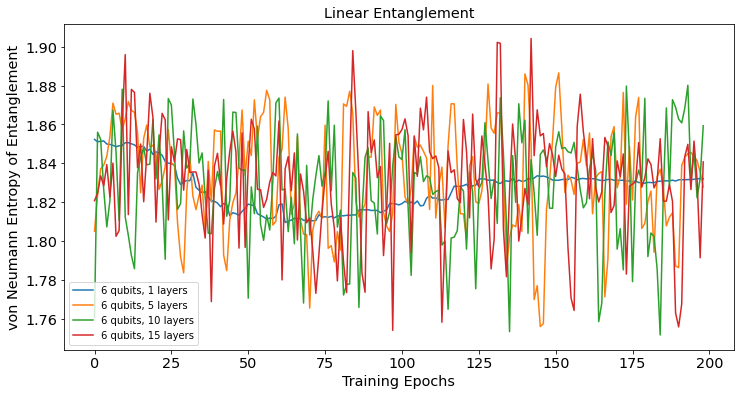

In [63]:
# plot the vN entropies for the Linear Entanglement with 6 qubits
plot_entropies(results['linear'][6])

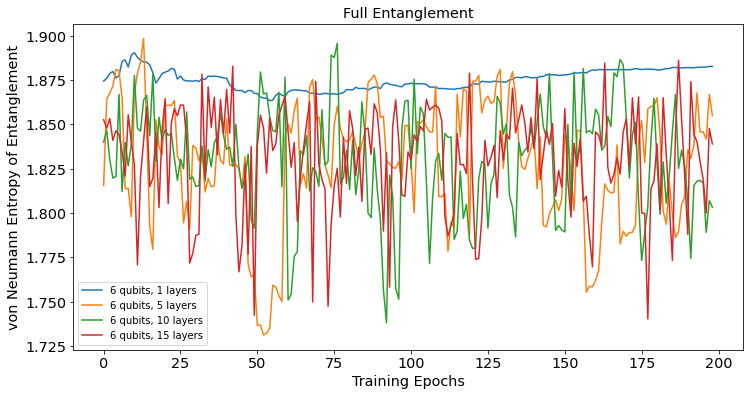

In [64]:
# plot the vN entropies for the Full Entanglement with 6 qubits
plot_entropies(results['full'][6])

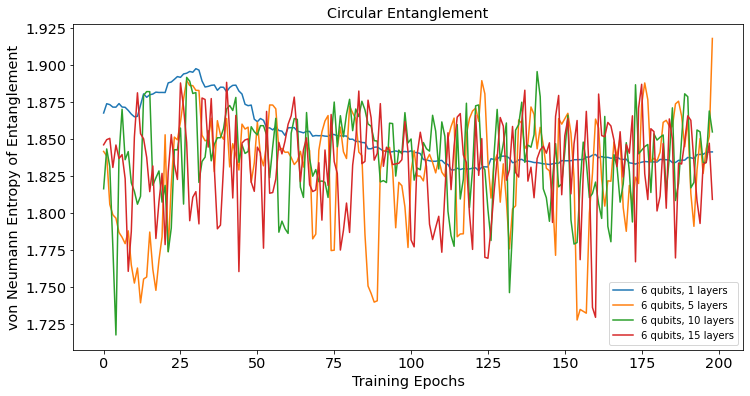

In [65]:
# plot the vN entropies for the Circular Entanglement with 6 qubits
plot_entropies(results['circular'][6])

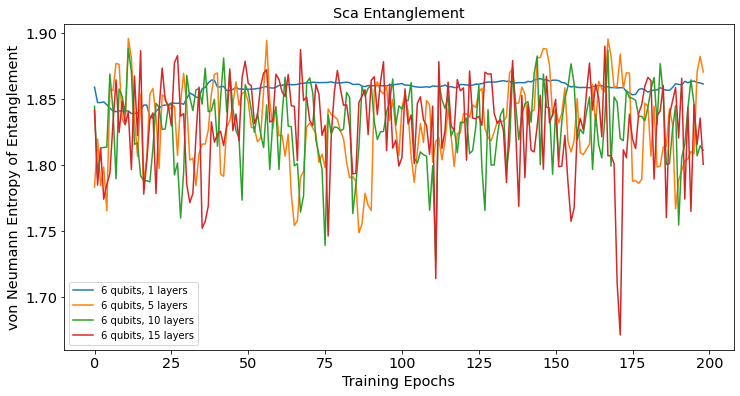

In [66]:
# plot the vN entropies for the SCA Entanglement with 6 qubits
plot_entropies(results['sca'][6])

## Entropy measures for the circuits using 7 qubits.

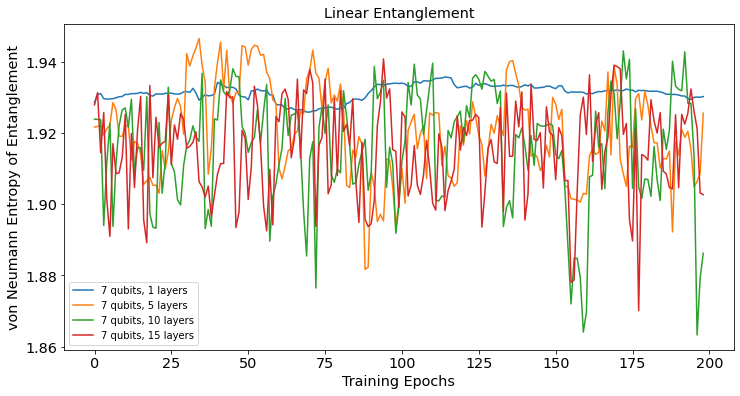

In [67]:
# plot the vN entropies for the Linear Entanglement with 7 qubits
plot_entropies(results['linear'][7])

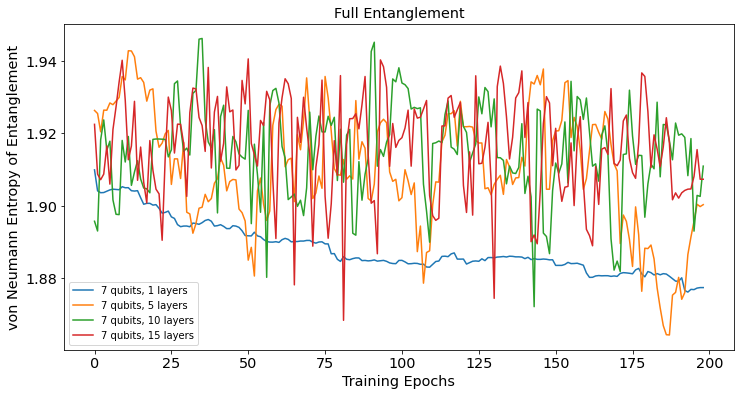

In [68]:
# plot the vN entropies for the Full Entanglement with 7 qubits
plot_entropies(results['full'][7])

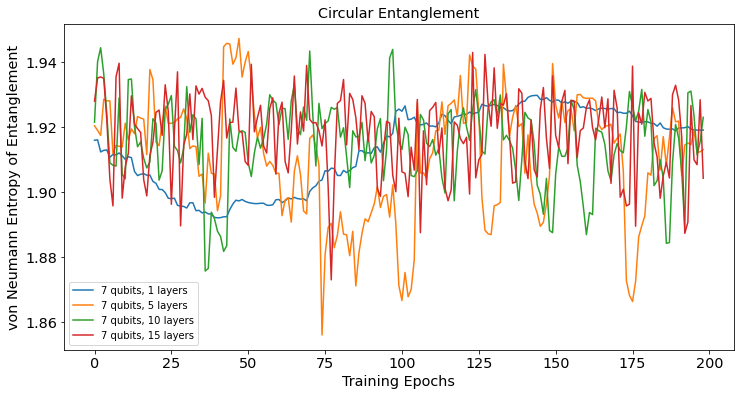

In [69]:
# plot the vN entropies for the Circular Entanglement with 7 qubits
plot_entropies(results['circular'][7])

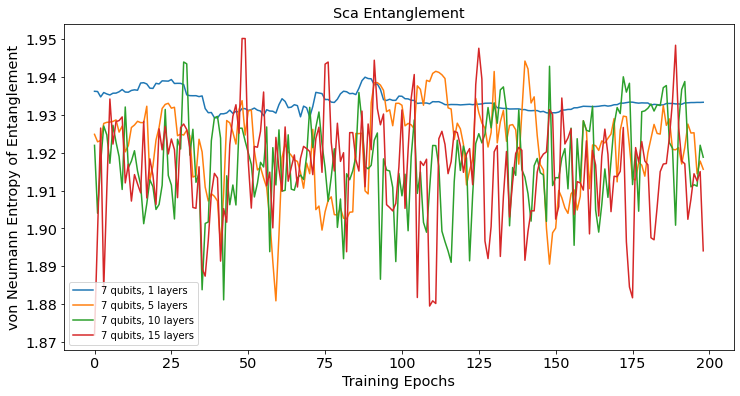

In [70]:
# plot the vN entropies for the SCA Entanglement with 7 qubits
plot_entropies(results['sca'][7])